# Conor Sayres
## HW3 Astro 597

Begin by importing the packages I'll be using throughout, and define some constants.

In [1]:
import numpy
import multiprocessing
from scipy import optimize
import time
import matplotlib.pyplot as plt
import rebound


AU = 149597870700  # m
secondsPerDay = 86400
mSun = 1.989e30  # kg
rSun = 6.95700e8 # m
mJupiter = 1.898e27  # kg
mEarth = 5.972e24  # kg
mStar = 0.32 * mSun  # (paper)
nTimesteps = 10000

G = 6.67408e-11  # m^3 kg^-1 s^-2

## Encoding orbital parameters for GJ 876 system
The orbital parameters for this system are given in the Rivera+ 2010 paper.  I'll begin by defining a general planet class, then populate each of the 4 planets (d, c, b, e) with the orbital parameters taken from Table 3: <img src="table3.png">.  Note that the planet class determines a mass for the object based on its inclination (as well as carying around the published mass for reference), which will be varied later when we simulate some orbits.

In [2]:
def getMassPlanet(x, K, P, e, i):
    # use this in a minimizer to solve for mass
    # must be in meters seconds radians kgs units and angles in radians!
    mp = x[0]
    a = 2 * numpy.pi * G / (mStar + mp)**2
    b = (mp * numpy.sin(i))**3
    c = P * (1 - e**2)**(3 / 2.)
    return K - (a * b / c)**(1 / 3.)

class Planet(object):
    def __init__(self, name, P, a, K, e, omega, MA, mPublished):
        # inputs in seconds, kg, radians, meters
        # P period in seconds
        # a semi-major axis in m
        # K velocity semi amplitude m/s
        # e eccentricity
        # omega: radians
        # MA: radians
        # mPublished = published mass value
        self.name = name
        self.P = P
        self.a = a
        self.K = K
        self.e = e
        self.omega = omega
        self.MA = MA
        self.mPublished = mPublished

        # lists for each model run
        self.i = []
        self.m = []
        self.model_a = []
        self.model_e = []
        self.model_x = []
        self.model_y = []

    def addInclination(self, i):
        # update inclination and mass
        self.i.append(i)
        sol = optimize.root(getMassPlanet, [self.mPublished], args=(self.K, self.P, self.e, i))
        self.m.append(float(sol.x[0]))
        self.model_a.append(numpy.zeros(nTimesteps))
        self.model_e.append(numpy.zeros(nTimesteps))
        self.model_x.append(numpy.zeros(nTimesteps))
        self.model_y.append(numpy.zeros(nTimesteps))

# Populate all planets from table 3 into classes
planetD = Planet(
    name="d",
    P=1.937780 * secondsPerDay,
    a=0.02080665 * AU,
    K=6.56,
    e=0.207,
    omega=numpy.radians(234),
    MA=numpy.radians(355),
    mPublished=6.83 * mEarth,
)

planetC = Planet(
    name="c",
    P=30.0881 * secondsPerDay,
    a=0.129590 * AU,
    K=88.34,
    e=0.25591,
    omega=numpy.radians(48.76),
    MA=numpy.radians(294.59),
    mPublished=0.7142 * mJupiter,
)

planetB = Planet(
    name="b",
    P=61.1166 * secondsPerDay,
    a=0.208317 * AU,
    K=214.00,
    e=0.0324,
    omega=numpy.radians(50.3),
    MA=numpy.radians(325.7),
    mPublished=2.2756 * mJupiter,
)

planetE = Planet(
    name="e",
    P=124.26 * secondsPerDay,
    a=0.3343 * AU,
    K=3.42,
    e=0.055,
    omega=numpy.radians(239),
    MA=numpy.radians(335),
    mPublished=14.6 * mEarth,
)

planets = [planetD, planetC, planetB, planetE]

## Vary the inclination, simulate orbits in Rebound
Below I run a series of rebound simulations for the system, varying inclination between 1 and 21 degrees.  The choice of timestep is 1/100 of period of the innermost planet, the simulation runs for 1000 orbits of the innermost planet.  I've elected to use the WH-Fast integrator for this.  Throughout the integration I'm saving snapshots of each objects semi-major axis, eccentricity, and x/y position.

In [3]:
inclinationList = numpy.arange(1, 21)
endTime = planetD.P * 1000  # 1000 orbits of shortest period planet
times = numpy.linspace(0, endTime, nTimesteps)
for inc in inclinationList:
    # print("simulating inclination %.2f" % inc)
    for planet in planets:
        planet.addInclination(numpy.radians(inc))
    sim = rebound.Simulation()
    sim.units = ('s', 'm', 'kg')
    sim.integrator = "whfast"
    sim.dt = planetD.P / 100.0  # shortest period

    sim.add(m=mStar)
    for planet in planets:
        sim.add(
            m=planet.m[-1],
            P=planet.P,
            M=planet.MA,
            omega=planet.omega,
            e=planet.e
        )
    sim.move_to_com()

    for i, t in enumerate(times):
        sim.integrate(t, exact_finish_time=0)

        for j, planet in enumerate(planets):
            planet.model_x[-1][i] = sim.particles[j+1].x
            planet.model_y[-1][i] = sim.particles[j+1].y
            planet.model_a[-1][i] = sim.particles[j+1].a
            planet.model_e[-1][i] = sim.particles[j+1].e

## Plot results vs inclincation, check orbital stability
Below I plot a grid of subplots showing each planet's semi-major axis as a function of time for each tested inclination.

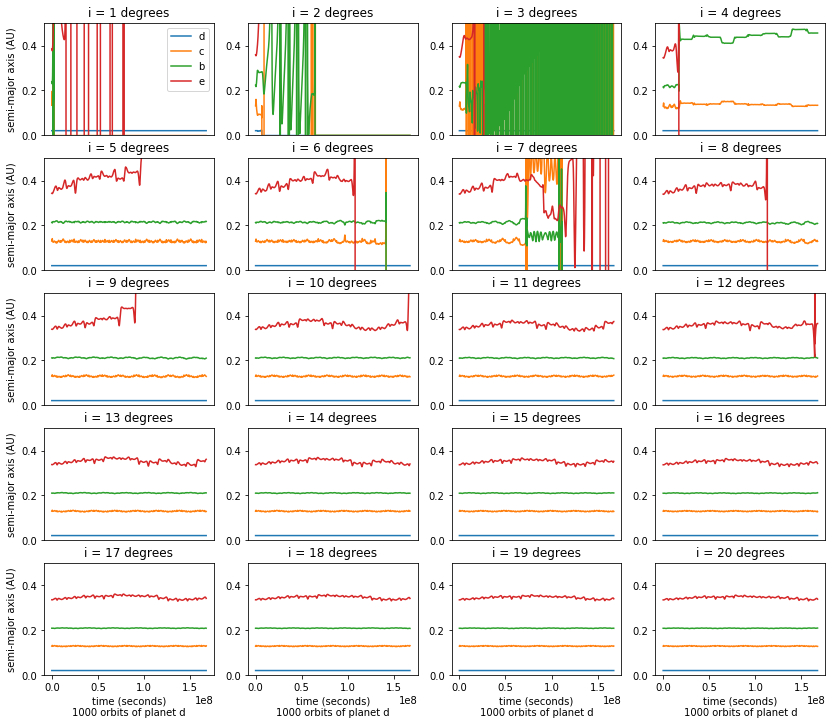

In [4]:
# plot results
fig, axGrid = plt.subplots(int(len(inclinationList)//4), 4, figsize=(14, 12))
axList = axGrid.flatten()
for i, (inc, ax) in enumerate(zip(inclinationList, axList)):
    for planet in planets:
        ax.plot(times, planet.model_a[i] / AU, label="%s"%planet.name)
        if inc < 17:
            ax.get_xaxis().set_ticks([])
        else:
            ax.set_xlabel("time (seconds)\n1000 orbits of planet d")
        if i % 4 == 0:
            ax.set_ylabel("semi-major axis (AU)")
        ax.set_ylim([0, planetE.a*1.5 / AU])
        ax.set_title("i = %i degrees"%inc)

axList[0].legend()
# figure out reasonable labels
plt.show()

## Upper limit masses
From the grid of plots, we see that the semi major axis remains relatively stable for all objects above 12 degrees.  So I'll say that 13 degrees inclination is the minimum inclination for a stable orbit (although my simulations do show a stable orbit for 11 degrees, because 12 degrees produces an unstable orbit, I'll choose the higher value).  Using an inclination value of 13 degrees for this system we can solve for the expected masses of the planets and consider this an upper bound.  The resulting masses are shown below.

In [5]:
### upper limit masses
ind = numpy.argwhere(inclinationList==13)[0][0] # index where inclination == 13
print("\nupper limit masses at inclination 13 deg:")
for planet in planets:
    print("planet %s mass: %.2f x (Earth Mass)"%(planet.name, planet.m[ind] / mEarth))


upper limit masses at inclination 13 deg:
planet d mass: 26.03 x (Earth Mass)
planet c mass: 868.75 x (Earth Mass)
planet b mass: 2788.34 x (Earth Mass)
planet e mass: 55.45 x (Earth Mass)


## Inclination of transit and lower limit masses
The equation for impact parameter $b$ is $$ b = a\frac{cos(i)}{r_{star}}\frac{1-e^2}{1+e sin(\omega)}$$
at $b=1$ we have a grazing transit, so setting $b=1$ and solving for $i$ we can determine the limiting inclination at which we would expect to see a transit.  Below I solve this equation for each of the planets, and then use the lowest found inclination value to put a lower limit on the massses.

In [6]:
rStar = 0.3 * rSun

print("\nTransit inclinations:")
for planet in planets:
    i = numpy.degrees(numpy.arccos(rStar / planet.a * (1 + planet.e * numpy.sin(planet.omega)) / (1 - planet.e**2)))
    print("planet %s transits at inclination: %.2f" % (planet.name, i))


i = numpy.radians(86.66) # lowest found inclination
print("\nlower limit masses at inclination 86.66 deg:")
for planet in planets:
    sol = optimize.root(getMassPlanet, [planet.mPublished], args=(planet.K, planet.P, planet.e, i))
    m = float(sol.x[0])
    print("planet %s mass: %.2f x (Earth Mass)"%(planet.name, m / mEarth))


Transit inclinations:
planet d transits at inclination: 86.66
planet c transits at inclination: 89.21
planet b transits at inclination: 89.61
planet e transits at inclination: 89.77

lower limit masses at inclination 86.66 deg:
planet d mass: 5.87 x (Earth Mass)
planet c mass: 194.94 x (Earth Mass)
planet b mass: 619.97 x (Earth Mass)
planet e mass: 12.49 x (Earth Mass)


## Simulate radial velocity for GJ 876
Below I use rebound to create a simulated radial velocity curve for GJ 876.  I'm only including the two most massive planets (c and b) to reduce the number of parameters required to fit the curve with pure Keplarian orbits (later).  Below I show the planet system face on, and then inclined to 59 degrees (the published inclination value).

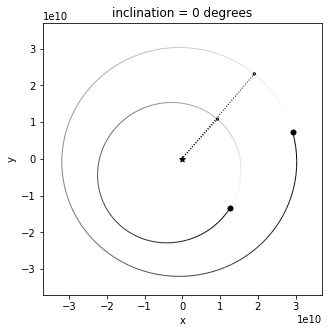

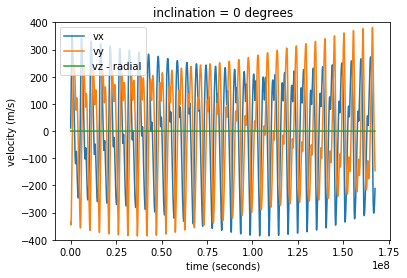

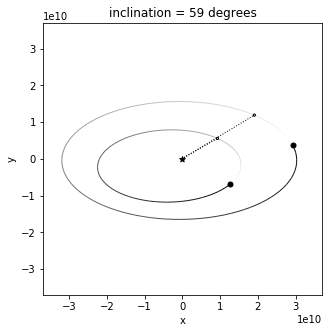

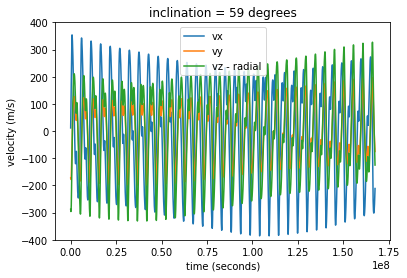

In [7]:
for inc in [0, 59]:
    # publishedInclination = numpy.radians(59)
    sim = rebound.Simulation()
    sim.units = ('s', 'm', 'kg')
    sim.integrator = "whfast"
    sim.dt = planetD.P / 100.0  # shortest period

    sim.add(m=mStar)
    for planet in [planetC, planetB]:
        sim.add(
            m=planet.mPublished,
            P=planet.P,
            M=planet.MA,
            omega=planet.omega,
            e=planet.e,
            inc=numpy.radians(inc),
        )
    sim.move_to_com()

    fig = rebound.OrbitPlot(sim, trails=True, periastron=True)
    plt.title("inclination = %i degrees"%inc)
#     plt.savefig("orbit_%i.png"%inc)
#     plt.close(fig)

    radialVx = numpy.zeros(nTimesteps)
    radialVy = numpy.zeros(nTimesteps)
    radialVz = numpy.zeros(nTimesteps)

    for i, t in enumerate(times):
        sim.integrate(t, exact_finish_time=0)
        radialVx[i] = sim.particles[0].vx
        radialVy[i] = sim.particles[0].vy
        radialVz[i] = sim.particles[0].vz
    plt.figure()
    # scale the radial velocity by the inclination angle
    plt.plot(times, radialVx, label="vx")
    plt.plot(times, radialVy, label="vy")
    plt.plot(times, radialVz, label="vz - radial")
    plt.title("inclination = %i degrees"%inc)
    plt.xlabel("time (seconds)")
    plt.ylabel("velocity (m/s)")
    plt.ylim([-400,400])
    plt.legend()
plt.show()
#     plt.savefig("rv_%i.png"%inc)
#     plt.close()

The plots above show the projection of the 0 and 59 degree orbits in the xy plane, and I also show the xyz velocities for the star.  The face on simulation shows no radial velocity (vz), but this inclined simulation does.  We'll use this vz curve, and try to fit Keplarians to it.

First define two functions to solve Kepler's equation and the solution for radial velocity.

In [8]:
def kepEq(x, M, e):
    E = x[0]
    return M - (E - e * numpy.sin(E))


def vRad(K, omega, e, Mlist):
    # ignore barycentric velocity
    h = K * numpy.cos(omega)
    c = -K * numpy.sin(omega)
    v_o = K * e * numpy.cos(omega)
    Es = numpy.zeros(len(Mlist))
    for ii, M in enumerate(Mlist):
        EGuess = [M + 0.85 * e * numpy.sin(numpy.sin(M))]
        sol = optimize.root(kepEq, EGuess, args=(M, e))
        E = float(sol.x[0])
        Es[ii] = E

    f = 2 * numpy.arctan(((1 + e) / (1 - e)**0.5 * numpy.tan(Es / 2)))
    return h * numpy.cos(f) + c * numpy.sin(f) + v_o

## Visualize rv curves for published orbital parameters
Below I'm plotting the RVs computed from planets c and b using the published values in the paper, showing both the computed and simulated (vz from wh-fast integrator) radial velocities, and the residuals between them.  First show the computed radial velocities for the two bodies.

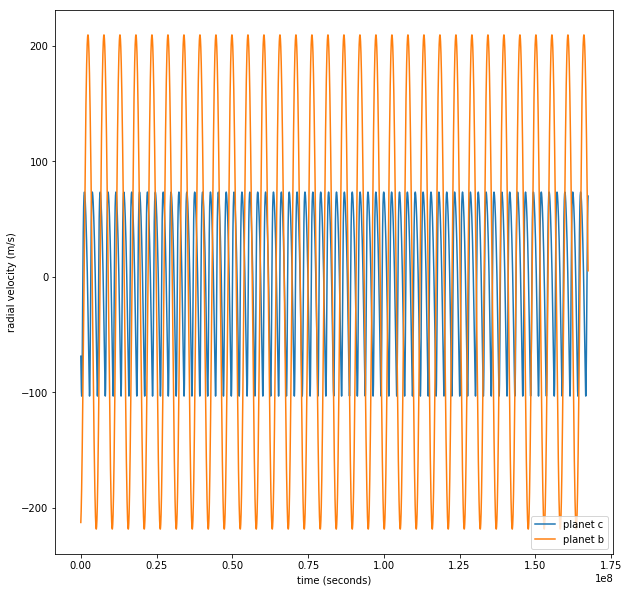

In [9]:
vRads = []
plt.figure(figsize=(10,10))
for planet in [planetC, planetB]:
    MList = planet.MA + 2 * numpy.pi / planet.P * (times - times[0])
    v = vRad(planet.K, planet.omega, planet.e, MList)
    v = -1*v # this was necessary
    plt.plot(times, v, label="planet %s"%planet.name)
    vRads.append(v)
plt.legend()
plt.xlabel("time (seconds)")
plt.ylabel("radial velocity (m/s)")
plt.show()
# plt.savefig("vr_components.png", dpi=150)
# plt.close()



Next, the summed computed radial velocities and residuals compared against our simulated vz from the rebound simulation.

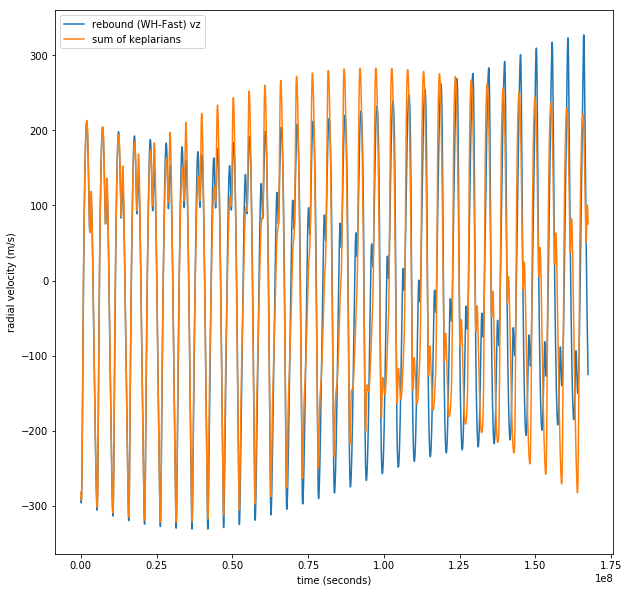

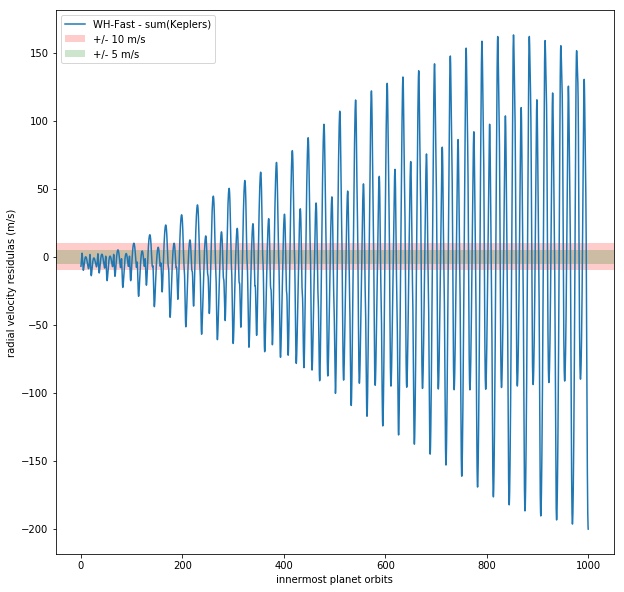

In [10]:
vRads = numpy.asarray(vRads)
vRadSum = numpy.sum(vRads, axis=0)
plt.figure(figsize=(10,10))
plt.plot(times, radialVz, label="rebound (WH-Fast) vz")
plt.plot(times, vRadSum, label="sum of keplarians")
plt.legend()
plt.xlabel("time (seconds)")
plt.ylabel("radial velocity (m/s)")
# plt.savefig("reboundVsKepler.png")
# plt.close()

### look at residuals
plt.figure(figsize=(10, 10))
plt.plot(times / planetD.P, radialVz - vRadSum, label="WH-Fast - sum(Keplers)")
p = plt.axhspan(-10, 10, facecolor='red', alpha=0.2, label="+/- 10 m/s")
p = plt.axhspan(-5, 5, facecolor='green', alpha=0.2, label="+/- 5 m/s")
plt.legend()
plt.ylabel("radial velocity residulas (m/s)")
plt.xlabel("innermost planet orbits")
# plt.savefig("residuals.png", dpi=150)
# plt.close()
plt.show()

## Varying orbital parameters to improve fit
Next, I'll code up a Keplarian solver to minimize the residuals between the simulated rv and computed rv for this 2 planet system.  Here I'm re-coding up the process I used in HW 1.  The Kepler solver accepts 3 parameters (e, P, and M), and solves for the other 3 (h, c, v_o) using the linearized Ax=b equation.

In [11]:
def getF(e, P, M):
    ### solve keplers eqn with newtons method
    Ms = M + 2 * numpy.pi / P * (times - times[0])
    Es = Ms + 0.85 * e * numpy.sign(numpy.sin(Ms))
    epsilon = 1e-8
    _iter = 0
    while True:
        _iter += 1
        if _iter > 1000:
            print("max iter reached!!!")
            raise RuntimeError("gah!")
        dEs = 1 - e * numpy.cos(Es)
        dEs[dEs==0] = 1e-16 # protect against zero division
        E_next = Es - (Es - e * numpy.sin(Es) - Ms) / dEs
        E_error = numpy.max(numpy.abs(Es - E_next))
        if E_error < epsilon:
            break
        Es = E_next
    fs = 2 * numpy.arctan( ((1+e)/(1-e))**0.5 * numpy.tan(Es/2.0) )
    return fs

def fitKeplers(x, nPlanets, measV):
    x = numpy.asarray(x).reshape(nPlanets,3)
    fs = [] # holds a list of fs for each planet
    for e, P, M in x:
        fs.append(getF(e, P, M))
    fs = numpy.asarray(fs)
    # linear solver for h, c, and v_o
    cosfs = numpy.cos(fs)
    sinfs = numpy.sin(fs)

    stack = numpy.vstack((cosfs, sinfs, numpy.ones(len(fs[0]))))

    # linear solver for h, c, and v_o
    # build array A
    A = []
    for element in stack:
        A.append(numpy.sum(element*stack, axis=1))
    A = numpy.asarray(A)

    # multiply every row of stack by measV
    measV = numpy.array([measV]*len(stack))
    b = numpy.sum(stack*measV, axis=1)

    coeffs = numpy.linalg.solve(A, b)
    rv = numpy.zeros(len(fs[0]))
    for coeff, row in zip(coeffs, stack):
        rv += coeff*row
    # next compute the chi2 and return it
    chi2 = numpy.sum((rv - measV)**2)
    return chi2, rv


def kepMinimizer(params, nPlanets, measV):
    chi2, rv = fitKeplers(params, nPlanets, measV)
    return chi2

I'm using a bounded minimization scheme, scipy's "trust-constr" to bound 0<=e<=1 0<=M<=2pi and P to within a factor of 200 from the published values for each planet.  This bounded minimizer seems to work well in avoiding problematic parameter space, and it's quick!

In [12]:
nPlanets = 2

initialParams = []
for planet in [planetC, planetB]:
    initialParams += [planet.e, planet.P, planet.MA]
initialParams = numpy.array(initialParams)

paramLowerBounds = [0, planetC.P/200., 0.1, 0, planetB.P/200., 0.1]
paramUpperBounds = [1, planetC.P*200, numpy.radians(359.9), 1, planetB.P*200, numpy.radians(359.9)]
bounds = optimize.Bounds(paramLowerBounds, paramUpperBounds)
res = optimize.minimize(kepMinimizer, initialParams, args=(nPlanets, radialVz), method='trust-constr', options={'verbose': 1}, bounds=bounds)
bestVals = res.x

chi, bestRV = fitKeplers(bestVals, nPlanets, radialVz)
print("minimizer chi2: %.5f"%chi)
print("minimizer found: ")
print("planet c | e=%.2f P=%.4f (days) MA=%.4f (degrees)"%(bestVals[0], bestVals[1]/secondsPerDay, numpy.degrees(bestVals[2])))
print("planet b | e=%.2f P=%.4f (days) MA=%.4f (degrees)"%(bestVals[0+3], bestVals[1+3]/secondsPerDay, numpy.degrees(bestVals[2+3])))

`xtol` termination condition is satisfied.
Number of iterations: 209, function evaluations: 2065, CG iterations: 476, optimality: 2.49e-02, constraint violation: 0.00e+00, execution time:  3.0 s.
minimizer chi2: 9316985.57777
minimizer found: 
planet c | e=0.11 P=30.2180 (days) MA=359.9000 (degrees)
planet b | e=0.01 P=61.0323 (days) MA=359.9000 (degrees)


Notice that the best found MA (Mean anomaly) values are pinned at the boundary.  This seems suspicious to me, but I can't figure out if there is a bone-fide bug in the strategy.  Anyhow lets visualize the results:

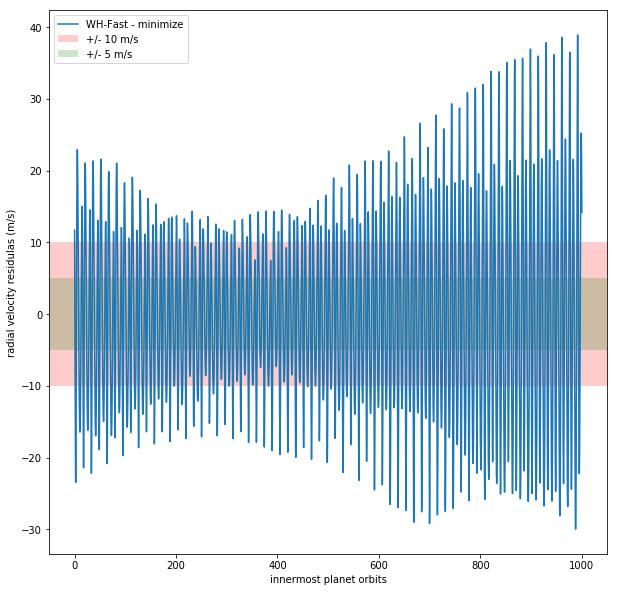

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(times / planetD.P, radialVz - bestRV, label="WH-Fast - minimize")
p = plt.axhspan(-10, 10, facecolor='red', alpha=0.2, label="+/- 10 m/s")
p = plt.axhspan(-5, 5, facecolor='green', alpha=0.2, label="+/- 5 m/s")
plt.legend()
plt.ylabel("radial velocity residulas (m/s)")
plt.xlabel("innermost planet orbits")
plt.show()

From the plot above, the minimizer was able to find orbital parameters such that the Keplarian solution (not including planet-planet interactions!) can fit the simulated rv data to almost completely within +- 30 m/s.  Due to instrumental sensitivity and stellar noise, radial velocities to 10 m/s are challenging (red region in plot above).  What I take away from this is that to differentiate between pure keplarian and models including planet-planet interactions, one would need to observe the system for a significant number of orbits, and have a pretty sensitive instrument! 

## TTV
The last task in this assignment is to compute the TTVs for the 4 planet system.  I've basically copied the TTV example from the rebound documentation and tweaked it to work for this case.  I'm assuming that all the parameters for the planets are those published, and showing the results we would see if we were viewing this system edge on.  First simulate the system using rebound and track the times at which the planet crosses infront of the star (assuming the observer is at +x in the rebound coordinate system).  Plot the results, varying the star mass up and down by a factor of 2.  Planet c's TTV are shown for a period of 4 years.

Planet C TTV amplitude for b = 0.5 is 11.90 hours
Planet C TTV amplitude for b = 1.0 is 13.51 hours
Planet C TTV amplitude for b = 2.0 is 67.55 hours


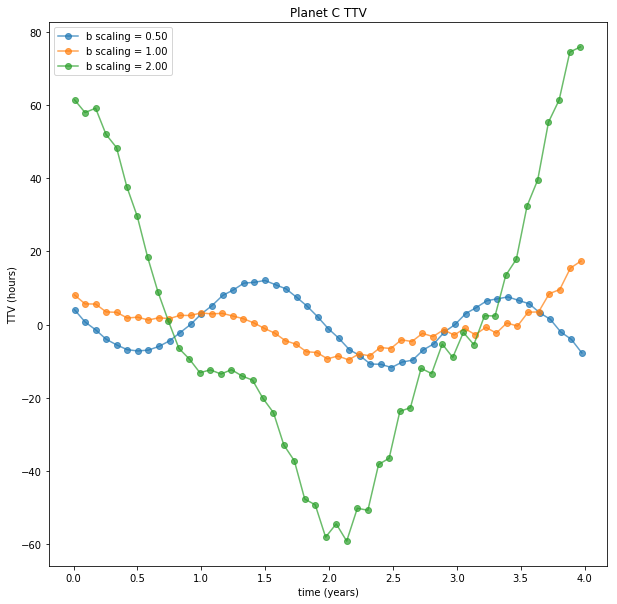

In [14]:

secondsPerYear = 3.154e7
endTime = 4 * secondsPerYear  # 1000 orbits of shortest period planet
plt.figure(figsize=(10,10))
for ratio in [1/2, 1, 2]:
    sim = rebound.Simulation()
    sim.units = ('s', 'm', 'kg')
    sim.integrator = "whfast"
    sim.dt = planetD.P / 100.0  # shortest period
    sim.add(m=mStar)
    for planet in planets:
        mass = planet.mPublished
        if planet.name == "b":
            mass *= ratio
        sim.add(
            m=mass,
            P=planet.P,
            M=planet.MA,
            omega=planet.omega,
            e=planet.e,
        )
    sim.move_to_com()

    transitTimes = []
    tStep = planetC.P / 100.0 # choose something less than C's period
    p = sim.particles
    # try catch crossings when the y coordinate moves from negative to positive
    while sim.t < endTime:
        # compare y coords of star and planet c
        # assumes the observer is at +x
        y_old = p[2].y - p[0].y # planet c - star
        t_old = sim.t
        sim.integrate(sim.t + tStep)
        t_new = sim.t
        if y_old*(p[2].y-p[0].y)<0 and p[2].x-p[0].x>0:
            # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new - t_old > 1e-7:
                if y_old*(p[2].y-p[0].y)<0:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate((t_new+t_old)/2.)
            transitTimes.append(sim.t)
            sim.integrate(sim.t+tStep)

    transitTimes = numpy.asarray(transitTimes)

    nTransits = len(transitTimes)
    transitNumber = range(nTransits)
    p = numpy.polyfit(transitNumber, transitTimes, deg=1)
    fitLine = p[0] * transitNumber + p[1]
    t = transitTimes / secondsPerYear
    ttv = (transitTimes - fitLine)/3600.0
    # amplitude
    amp = (max(ttv)-min(ttv))/2.
    print("Planet C TTV amplitude for b = %.1f is %.2f hours"%(ratio, amp))
    
    plt.plot(t, ttv, '-o', alpha=0.7, label="b scaling = %.2f"%(ratio))

plt.title("Planet C TTV")
plt.xlabel("time (years)")
plt.ylabel("TTV (hours)")
plt.legend()
plt.show()

The amplitude of planet c's TTV grows with increasing planet b's mass (printed above).  From visual inspection the TTV period is seems shortest when b = 1 at ~1.7 years, but it could be argued to be longer. It's hard to tell from my perspective.  The longest period is when b = 2 at ~4 years. b = 0.5 yields a period of about 1.9 years